In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [4]:
f(3.0)

20.0

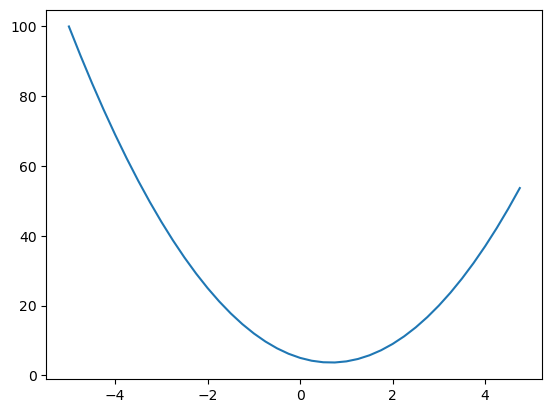

In [5]:
xs = np.arange(-5.0, 5.0, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2 / 3
# 计算导数 derivative
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [7]:
# 计算d对a、b、c的导数
a = 2.0
b = -3.0
c = 10
d = a * b + c
print(d)


4.0


In [8]:
h = 0.0001
d1 = a * b + c
b += h
d2 = a * b + c
print(d1, d2)
# d对a的导数是b， d对b的导数是a，d对c的导数是1
print((d2 - d1) / h)

4.0 4.0002
2.0000000000042206


In [129]:
class Value:
    def __init__(self, data, children=None, op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children) if children else ()
        self._op = op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self.data + other.data
        out = Value(out, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self.data * other.data
        out = Value(out, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):  # self-other
        return self + (-other)
    
    def __neg__(self):  # -self
        return self * -1

    def __truediv__(self, other):
        # x/y == x*y**-1
        return self * other ** -1

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = self.data ** other.data
        out = Value(out, (self, other), "pow")

        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        # tanh x = e的2x次方减1 除以 e的2x次方加1
        x = self.data
        v = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(v, (self,), 'tanh')

        def _backward():
            self.grad += (1 - v ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        # 拓扑排序，只会沿着从左向右一个方向
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10, label='c')
# e = a * b
# e.label = 'e'
# d = e + c
# d.label = 'd'
# f = Value(-2, label='f')
# L = d * f
# L.label = 'L'

In [10]:
d._prev

{Value(-6.0), Value(10)}

In [11]:
d._op

'+'

In [12]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

In [23]:
from graphviz import Digraph


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR指from left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # 给所有node创建一个长方形标签
        dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape="record")
        if n._op:
            # 如果是一个运算节点，创建一个椭圆形标签，并指向运算结果节点
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # 创建指向运算节点的箭头
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [25]:
# 通过反向计算最终结果L对每一个节点的导数
# 链式规则  dz/dx = (dz/dy) * (dy/dx)
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = 1.0
e.grad = 1.0
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

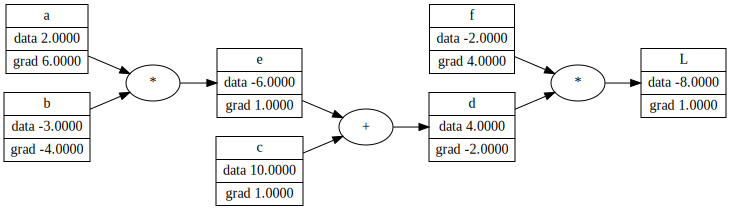

In [27]:
draw_dot(L)

In [28]:
# 叶子节点
# 导数告诉我们的是当前项变化时对最终输出结果的影响
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.3452959999999985


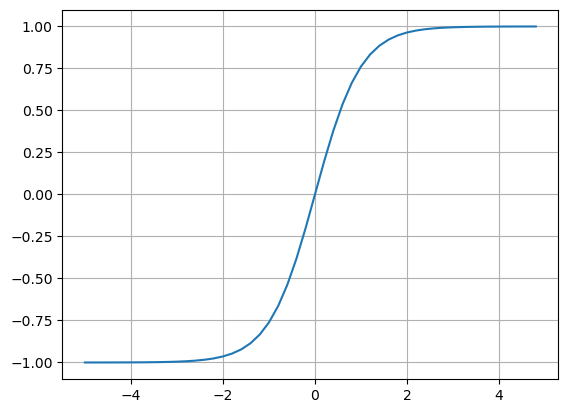

In [37]:
arr = np.arange(-5, 5, 0.2)
plt.plot(arr, np.tanh(arr))
plt.grid()

In [73]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'



In [53]:
# 手动计算
o.grad = 1
# d(o)/d(n) = 1 - tanh(n)的平方
# o = tanh(n)
n.grad = 1 - o.data ** 2  # 0.5
# 加法,导数都一样
x1w1.grad = x2w2.grad = x1w1x2w2.grad = b.grad = n.grad
# 乘法，根据chain rule计算
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [63]:
# 自动计算
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()

In [70]:
# 全自动计算
o.grad = 1
# 拓扑排序，只会沿着从左向右一个方向
topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)
for node in reversed(topo):
    node._backward()

In [75]:
o.backward()

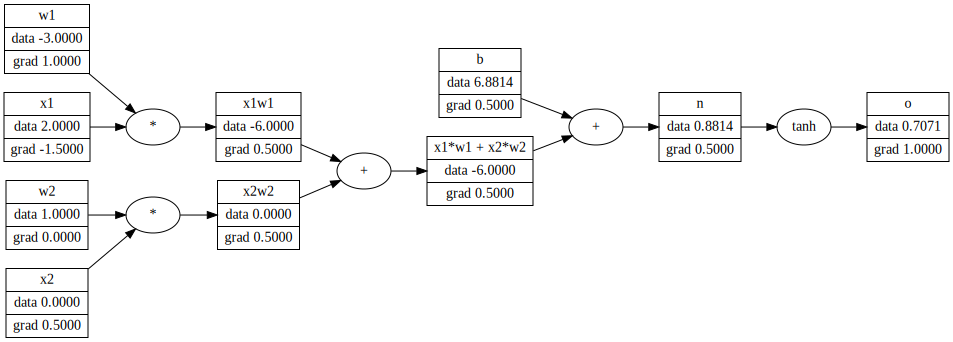

In [76]:
draw_dot(o)

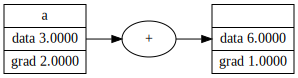

In [86]:
a = Value(3, label='a')
b = a + a
b.backward()
draw_dot(b)

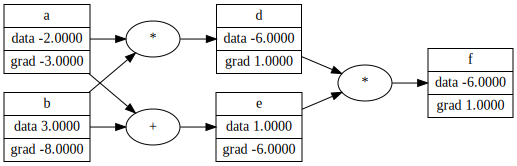

In [90]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()

draw_dot(f)

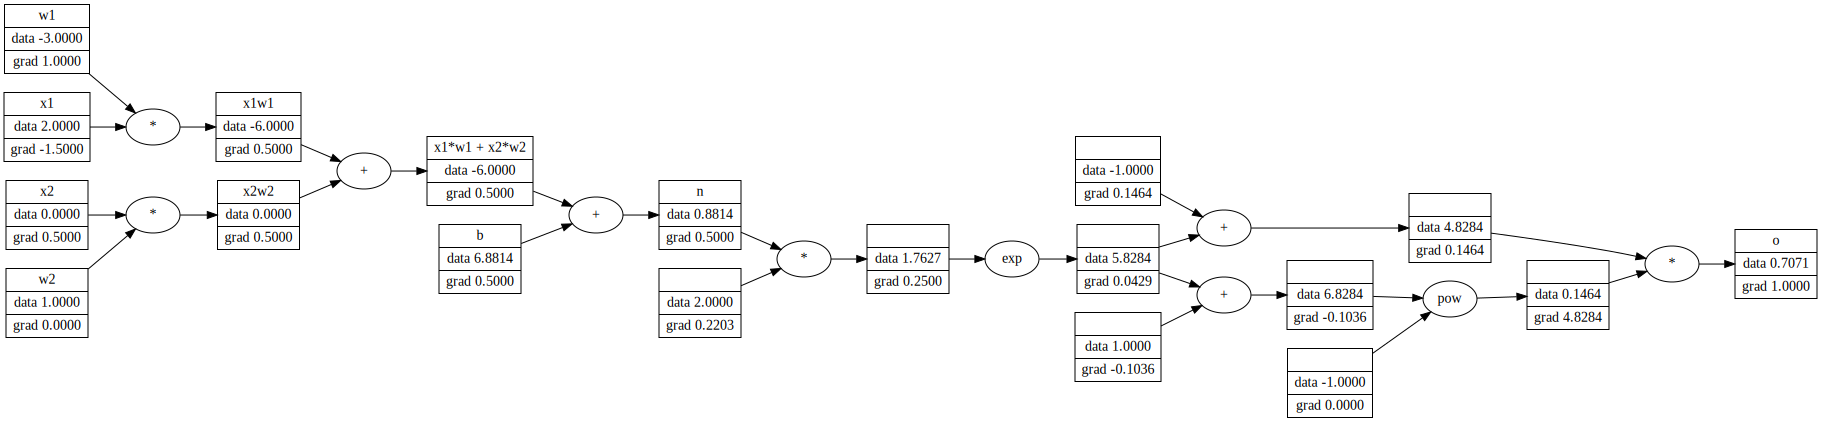

In [101]:
# 对某一个步骤求导，或者把这个步骤再拆解细分求导，完全取决于你
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
# o = n.tanh()
# tanh(x) = e的2x次方-1 / e的2x次方+1
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

draw_dot(o)


In [102]:
# 下面用pytorch做同样的事情
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.88137]).double()

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print("------------")
print("x1:", x1.grad.item())
print("x2:", x2.grad.item())
print("w1:", w1.grad.item())
print("w2:", w2.grad.item())

0.7071050214706146
------------
x1: -1.500007465833125
x2: 0.5000024886110417
w1: 1.0000049772220834
w2: 0.0


In [107]:
o.data.item()

0.7071050214706146

In [133]:
import random


class Neuron:
    def __init__(self, n_in):
        self.weight = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.bias = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w*x +b
        act = sum(w * x for w, x in zip(self.weight, x)) + self.bias
        print(act)
        out = act.tanh()
        return out


x = [2.0, -3.0]
n = Neuron(2)
n(x)

Value(-0.9474945946419904)


Value(-0.7386466977580317)

In [121]:
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


l = Layer(4, 4)
l(x)

[Value(-0.954439864291649),
 Value(0.7052791888614007),
 Value(0.9972819675413538),
 Value(0.6777513450668274)]

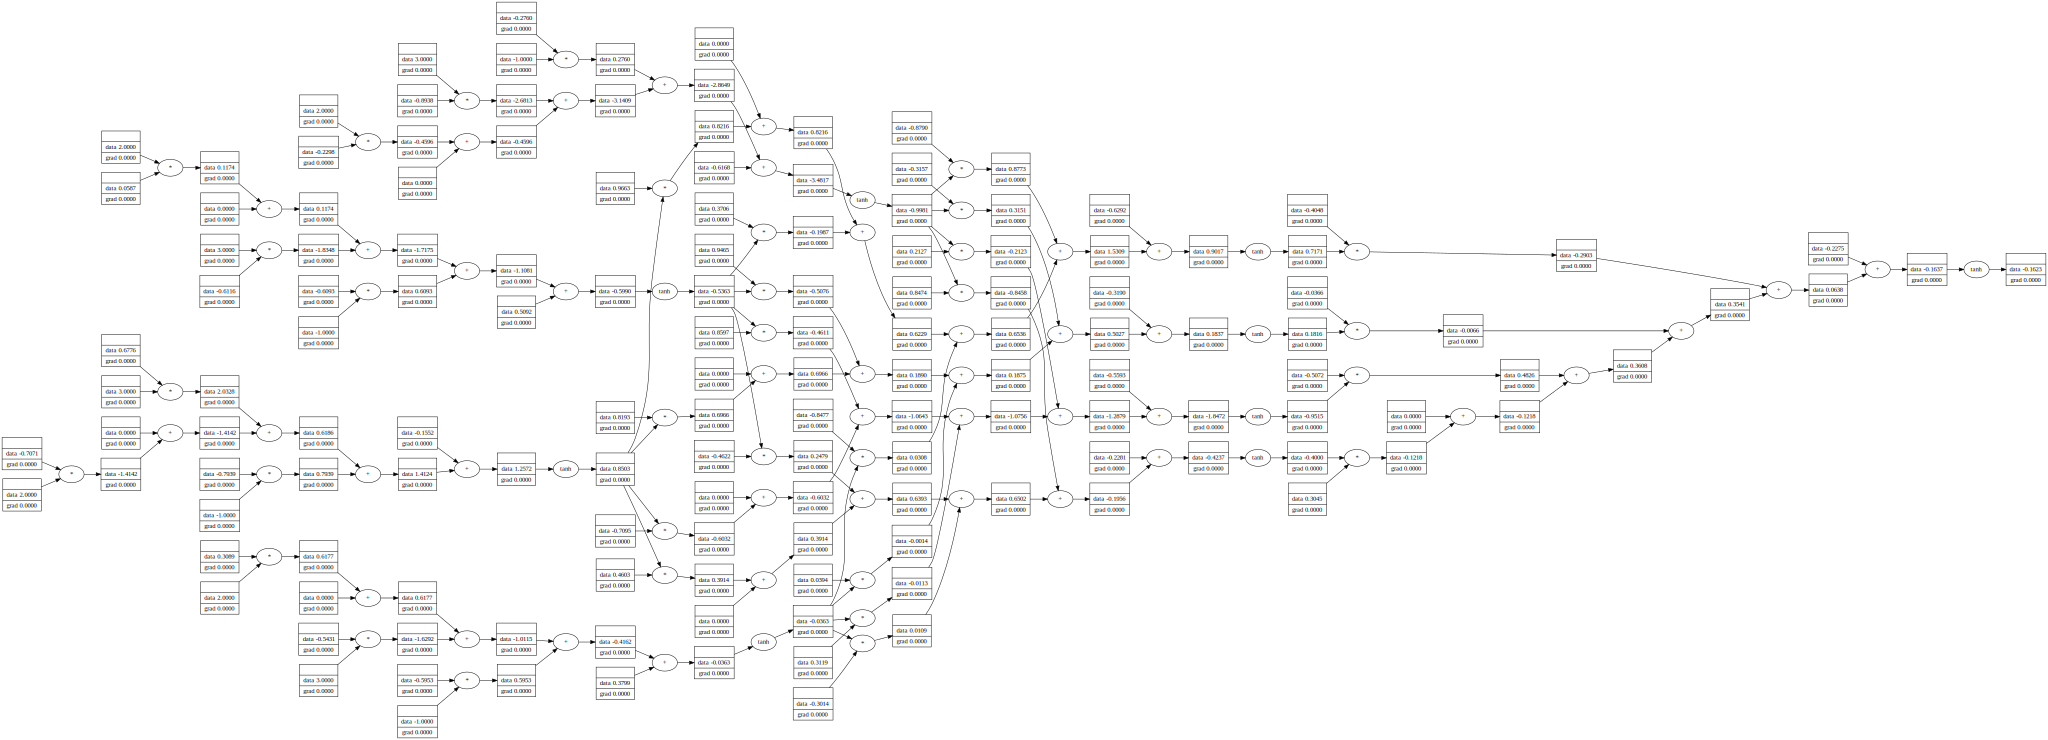

In [125]:
class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(n_outs))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
x = [2.0, 3.0, -1.0]
m = MLP(3, [4,4,1])
o = m(x)
draw_dot(o)

In [131]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets